In [1]:
import glob
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
import os
from build import build_model
import coralme

In [2]:
from IPython.display import display, HTML, Math, Markdown
display(HTML("<style>.container { width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2

In [3]:
FluxesByOrganism = {}
for c in ["nonIBD","IBD"]:
    FluxesByOrganism[c] = pandas.read_csv("./datasets/3.6.TotalFluxes_{}.csv".format(c),index_col=0)

In [113]:
met = "EX_for(e)"
Taxa = "Family"

In [114]:
RankByMet = pandas.DataFrame()
for k,v in FluxesByOrganism.items():
    RankByMet[k] = v.loc[met]

In [115]:
taxonomy = pandas.read_csv("./taxonomy.txt",index_col=0,sep='\t')
taxonomy = taxonomy[taxonomy["Kingdom"]=="Bacteria"]

### Get ranks

In [116]:
rank = pandas.DataFrame()
for col in RankByMet.columns:
    tmp = RankByMet[col].sort_values()
    rank[col] = tmp.rank()
rank = rank.fillna(rank.shape[0])

In [117]:
df = pandas.concat([rank,taxonomy],axis=1).dropna()

### Mann-Whitney test

In [118]:
from scipy.stats import mannwhitneyu
def mannwhitney(taxa, col,alt="greater"):
    taxa_df = df[df[Taxa] == taxa]
    y = taxa_df["nonIBD"].values
    x = taxa_df[col].values
    return mannwhitneyu(x,y , method="exact", alternative=alt)

### Mann-Whitney test for advantaged

In [119]:
dct = {}
for col in RankByMet.drop("nonIBD",axis=1).columns:
    dct[col] = {}
    for taxa in df[Taxa].unique():
        U1, p = mannwhitney(taxa,col,alt="greater")
        dct[col][taxa] = p
adv = pandas.DataFrame.from_dict(dct)

In [120]:
cmap_df = adv.copy()
# cmap_df = cmap_df[(cmap_df<0.1).any(axis=1)] # Only significant
cmap_df = -numpy.log10(cmap_df).sort_values("IBD")

/tmp/ipykernel_1594643/1968590180.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds').copy()


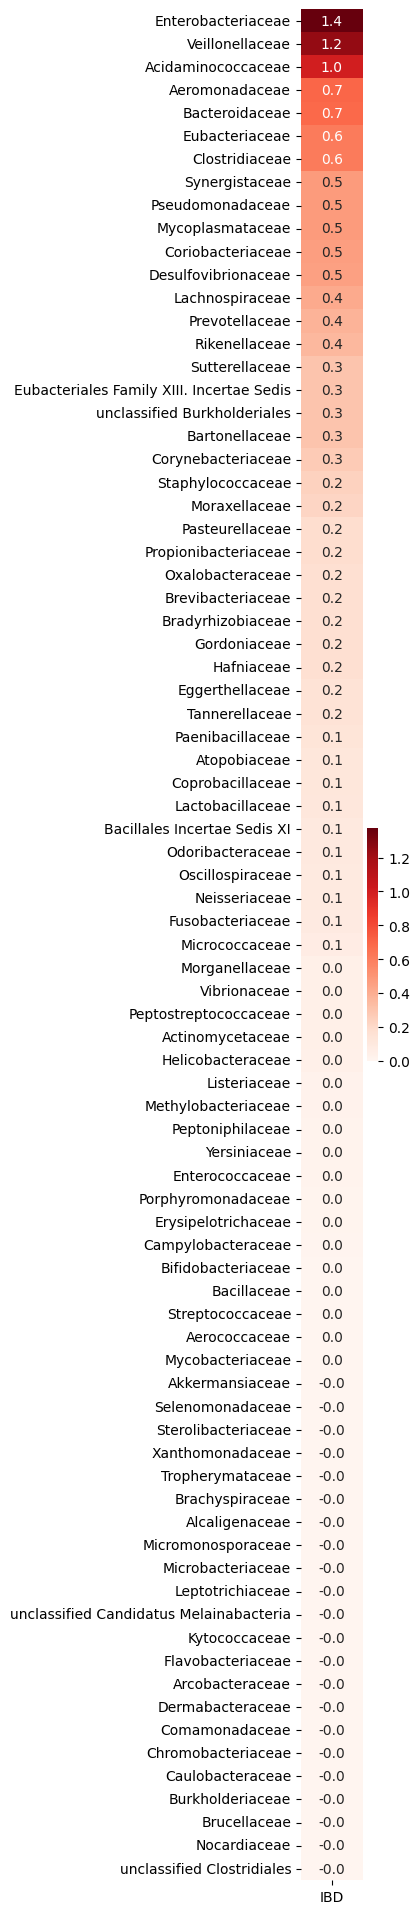

In [121]:
import seaborn as sns
fig,ax = plt.subplots(1,1, figsize=(1.0*cmap_df.shape[1],(0.3)*cmap_df.shape[0]))
cmap = plt.cm.get_cmap('Reds').copy()
# cmap.set_under('white')
cmap = sns.heatmap(cmap_df,
               # vmin=vmin,
               # vmax=vmax,
               annot=True,
               fmt=".1f",
               cmap=cmap,
               # annot_kws={'rotation': 90}
               # cbar=False,
              )
# cmap.ax_heatmap.set_xticklabels(cmap.ax_heatmap.get_xticklabels(), rotation=90)
# _=plt.setp(cmap.ax_heatmap.get_xticklabels(), rotation=80)

### Mann-Whitney test for disadvantaged

In [30]:
dct = {}
for col in growth.drop("base",axis=1).columns:
    dct[col] = {}
    for taxa in df["Genus"].unique():
        U1, p = mannwhitney(taxa,col,alt="less")
        dct[col][taxa] = p
dadv = pandas.DataFrame.from_dict(dct)

/tmp/ipykernel_1176136/2834304706.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues').copy()


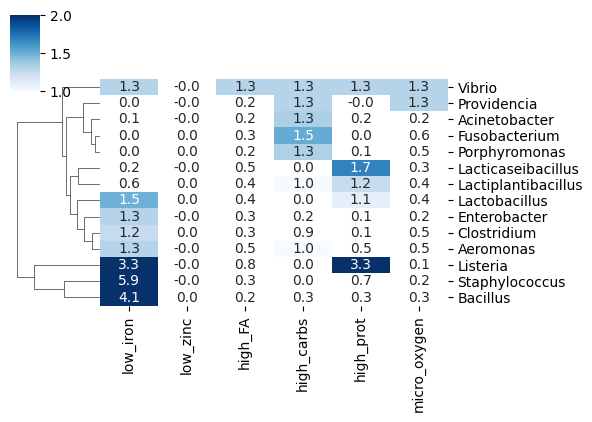

In [31]:
import seaborn as sns
cmap_df = dadv.copy()
cmap_df = cmap_df[(cmap_df<0.1).any(axis=1)] # Only significant
cmap_df = -numpy.log10(cmap_df)
cmap = plt.cm.get_cmap('Blues').copy()
cmap.set_under('white')
vmin,vmax = (1.0,2)
cmap = sns.clustermap(cmap_df,
               row_cluster=True,
               col_cluster=False,
               vmin=vmin,
               vmax=vmax,
               annot=True,
               fmt=".1f",
               cmap=cmap,
               # annot_kws={'rotation': 90}
               figsize=(1.0*cmap_df.shape[1],(0.3)*cmap_df.shape[0]),
               # cbar=False,
              )
labels = [i.get_text() for i in cmap.ax_heatmap.yaxis.get_majorticklabels()]

/tmp/ipykernel_1176136/3530064139.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues').copy()


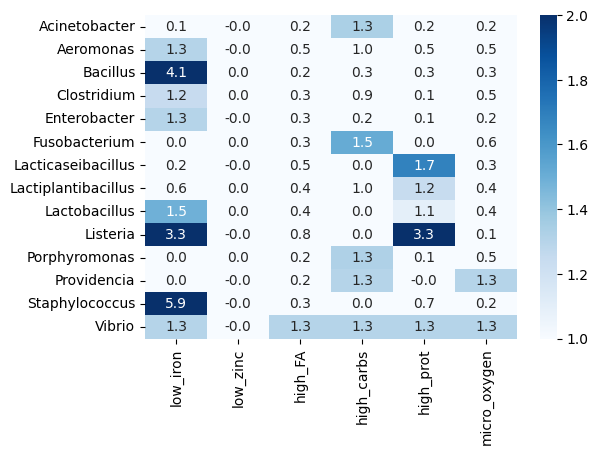

In [32]:
import seaborn as sns
fig,ax = plt.subplots(1,1, figsize=(1.0*cmap_df.shape[1],(0.3)*cmap_df.shape[0]))
cmap = plt.cm.get_cmap('Blues').copy()
# cmap.set_under('white')
cmap = sns.heatmap(cmap_df.loc[labels].sort_index(),
               vmin=vmin,
               vmax=vmax,
               annot=True,
               fmt=".1f",
               cmap=cmap,
               # annot_kws={'rotation': 90}
               # cbar=False,
              )
# cmap.ax_heatmap.set_xticklabels(cmap.ax_heatmap.get_xticklabels(), rotation=90)
# _=plt.setp(cmap.ax_heatmap.get_xticklabels(), rotation=80)

plt.savefig("./figures/2.3.3.MW-heatmap-less.svg",format="SVG")